# VQ-VAE

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import torch.nn.functional as F
from datetime import datetime

In [2]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, dim_embeddings):
        super().__init__()

        self.num_embeddings = num_embeddings

        self.embedding = nn.Embedding(num_embeddings, dim_embeddings)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, x, return_indices=False):
        x_permuted = x.permute(0, 2, 3, 1).contiguous()
        x_flatted = x_permuted.view(-1, x.shape[1])

        # Using Broadcasting: (N, 1, dim_embeddings) - (num_embeddings, dim_embeddings) = (N, num_embeddings, dim_embeddings)
        indices = torch.norm(x_flatted.unsqueeze(1) - self.embedding.weight, dim=2).argmin(dim=1)

        if return_indices:
            return indices.view(x.shape[0], x.shape[2], x.shape[3])

        quantized = self.embedding(indices) # (-1, dim_embeddings)

        return quantized.view(x_permuted.shape).permute(0, 3, 1, 2)


print(VectorQuantizer(10, 100)(torch.randn(32, 100, 4, 4)).shape)
VectorQuantizer(10, 100)(torch.randn(32, 100, 4, 4), return_indices=True).shape

torch.Size([32, 100, 4, 4])


torch.Size([32, 4, 4])

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()

        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, in_channels, kernel_size=1)
        )
    
    def forward(self, x):
        return x + self.net(x)
    
ResidualBlock(10, 20)(torch.randn(16, 10, 28, 28)).shape

torch.Size([16, 10, 28, 28])

In [4]:
class Encoder(nn.Module):
    def __init__(self, img_channels=3, dim_hidden=256):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(img_channels, dim_hidden, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim_hidden, dim_hidden, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(dim_hidden, dim_hidden),
            ResidualBlock(dim_hidden, dim_hidden),
            nn.Conv2d(in_channels=dim_hidden, out_channels=dim_hidden, kernel_size=1, stride=1)
        )
    
    def forward(self, x):
        return self.net(x)

Encoder()(torch.randn(16, 3, 28, 28)).shape

torch.Size([16, 256, 7, 7])

In [5]:
class Decoder(nn.Module):
    def __init__(self, dim_hidden=256, img_channels=3):
        super().__init__()

        self.net = nn.Sequential(
            ResidualBlock(dim_hidden, dim_hidden),
            ResidualBlock(dim_hidden, dim_hidden),
            nn.ConvTranspose2d(dim_hidden, dim_hidden, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(dim_hidden, img_channels, kernel_size=4, stride=2, padding=1),
        )
    
    def forward(self, x):
        return self.net(x)

Decoder()(torch.randn(16, 256, 7, 7)).shape

torch.Size([16, 3, 28, 28])

## Train on MNIST

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = torchvision.datasets.MNIST('../data/mnist', train=True, transform=transform, download=False)

dataset[0][0].min(), dataset[0][0].max()

(tensor(0.), tensor(1.))

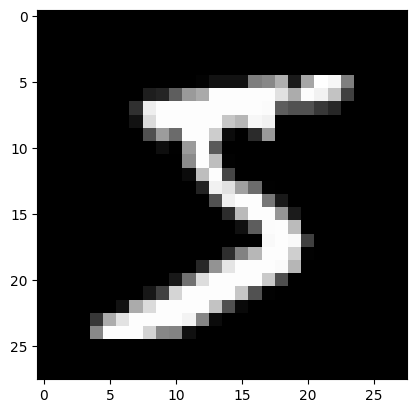

In [7]:
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray');

In [8]:
def show_images(images, nrow=8, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
data_variance = np.var(dataset.data.numpy() / 255.0)
data_variance

0.09493041879725218

In [11]:
LAMBDA_COMMITMENT = 0.25
NUM_EMBEDDINGS = 50
DIM_EMBEDDINGS = 64

In [12]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

encoder = Encoder(img_channels=1, dim_hidden=DIM_EMBEDDINGS).to(device)
decoder = Decoder(dim_hidden=DIM_EMBEDDINGS, img_channels=1).to(device)
vq = VectorQuantizer(num_embeddings=NUM_EMBEDDINGS, dim_embeddings=DIM_EMBEDDINGS).to(device)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(vq.parameters()), lr=1e-3)

reconstruction_loss = nn.MSELoss()

Reconstruction: 0.06399776041507721 - loss2: 0.04214734584093094 - Commitment: 0.010536836460232735


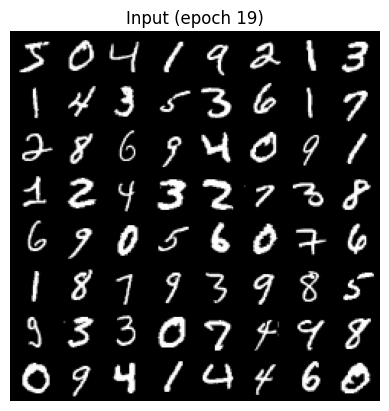

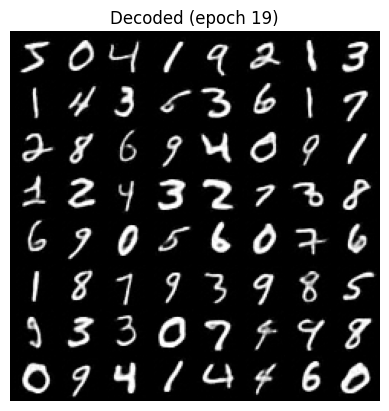

In [13]:
for epoch in range(20):
    epoch_loss = 0.

    for images, _ in train_loader:
        images = images.to(device)

        encoded = encoder(images)
        quantized = vq(encoded)
        decoded = decoder(encoded + (quantized - encoded).detach())

        loss2 = torch.norm(encoded.detach() - quantized)**2
        commitment_loss = LAMBDA_COMMITMENT * torch.norm(encoded - quantized.detach())**2
        recon_loss = reconstruction_loss(decoded, images) / data_variance
        loss = recon_loss + loss2 + commitment_loss
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    clear_output()
    print("Reconstruction:", recon_loss.item(), "- loss2:", loss2.item(), "- Commitment:", commitment_loss.item())
    show_images(torch.stack([dataset[i][0] for i in range(64)]), title=f'Input (epoch {epoch})');
    
    encoded = encoder(torch.stack([dataset[i][0] for i in range(64)]).to(device))
    decoded = decoder(vq(encoded))

    show_images(decoded.cpu().clip(0, 1), title=f'Decoded (epoch {epoch})');

In [26]:
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')
torch.save(vq.state_dict(), 'vq.pth')

# encoder.load_state_dict(torch.load('encoder.pth'))
# decoder.load_state_dict(torch.load('decoder.pth'))
# vq.load_state_dict(torch.load('vq.pth'));